Gaussian Processes

Source: 
- https://scikit-learn.org/stable/modules/gaussian_process.html
- https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy

In [2]:
# Generate data
rng = np.random.RandomState(3)
X = rng.uniform(0, 5, 5)[:, np.newaxis]
y = np.sin((X[:, 0] - 2.5) ** 2)

# sklearn (gaussian_process)

Prediction with GP Prior

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

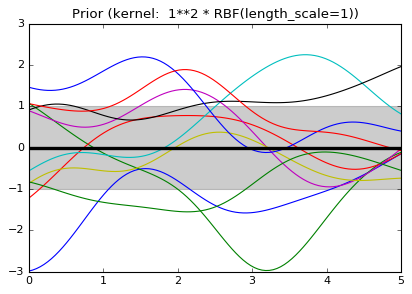

In [4]:
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))
gp = GaussianProcessRegressor(kernel=kernel)

# test points
X_ = np.linspace(0, 5, 100)

# mean
y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.ylim(-1.5,1.5)
plt.fill_between(X_, y_mean - y_std, y_mean + y_std, alpha=0.2, color='k')

# draw samples
y_samples = gp.sample_y(X_[:, np.newaxis], 10)
plt.plot(X_, y_samples, lw=1)
plt.xlim(0, 5)
plt.ylim(-3, 3)
plt.title("Prior (kernel:  %s)" % kernel, fontsize=12)

Prediction with GP Posterior using GP library in sklearn

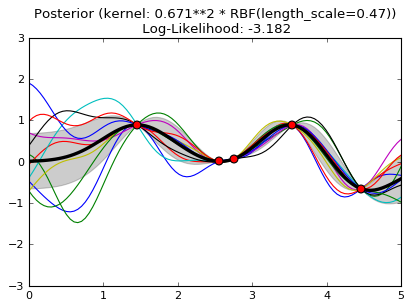

In [5]:
gp.fit(X, y)
X_ = np.linspace(0, 5, 100)
y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_, y_mean - y_std, y_mean + y_std,
                 alpha=0.2, color='k')

y_samples = gp.sample_y(X_[:, np.newaxis], 10)
plt.plot(X_, y_samples, lw=1)
plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.xlim(0, 5)
plt.ylim(-3, 3)
plt.title("Posterior (kernel: %s)\n Log-Likelihood: %.3f"
          % (gp.kernel_, gp.log_marginal_likelihood(gp.kernel_.theta)),
          fontsize=12)

# re-implementation

Prediction with GP Prior

In [6]:
from sklearn.metrics.pairwise import rbf_kernel

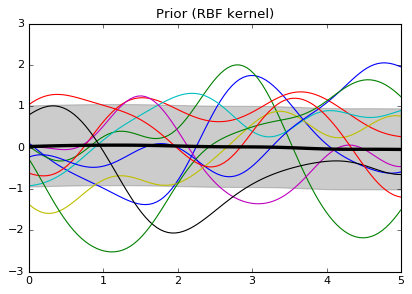

In [7]:
# test points
dim_X = 100
X_ = np.linspace(0, 5, dim_X)
K_XX_ = rbf_kernel(X_[:, np.newaxis], X_[:, np.newaxis], gamma=1) # covariance f

# verify mean, variance by monte carlo estimate
samples_MC = np.random.multivariate_normal(
  mean=np.zeros(dim_X), cov=K_XX_, size=1000).T
y_mean = np.mean(samples_MC, axis=1)
y_std = np.std(samples_MC)
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_, y_mean - y_std, y_mean + y_std, alpha=0.2, color='k')

# samples
y_ = np.random.multivariate_normal(
  mean=np.zeros(dim_X), cov=K_XX_, size=10).T
plt.plot(X_, y_, lw=1)
plt.xlim(0, 5)
plt.ylim(-3, 3)
plt.title("Prior (RBF kernel)", fontsize=12)

Prediction with GP Posterior

Since the GP library in sklearn performs hyperparameter search during fitting, the result of the vanilla implementation based on GPonML book is different.

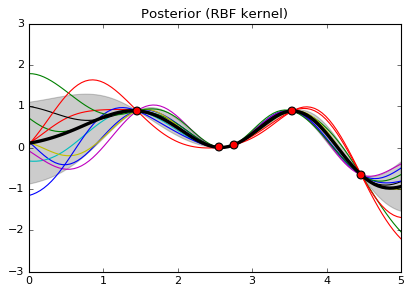

In [8]:
# use train points to fit
K_XX = rbf_kernel(X, X, gamma=1)
L = np.linalg.cholesky(K_XX)
assert np.allclose(L, np.tril(L)), "L is not lower triangular"
alpha = scipy.linalg.cho_solve((L,True), y)

# predictive mean, predictive variance
dim_X = 100
X_ = np.linspace(0, 5, dim_X)
K_XX_ = rbf_kernel(X, X_[:, np.newaxis], gamma=1)
K_X_X_ = rbf_kernel(X_[:, np.newaxis], X_[:, np.newaxis], gamma=1)
y_mean = np.dot(K_XX_.T, alpha)
z = scipy.linalg.cho_solve((L,True), K_XX_) # L.T z = v
y_cov = K_X_X_ - np.dot(K_XX_.T, z)
# follow book notation:
# v = np.dot(L.T, z)
# y_cov = K_X_X_ - np.dot(v.T, v)
y_std = np.sqrt(np.diag(y_cov))
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_, y_mean - y_std, y_mean + y_std, alpha=0.2, color='k')

# predictive samples
y_ = np.random.multivariate_normal(
  mean=y_mean, cov=y_cov, size=10).T
plt.plot(X_, y_, lw=1)
plt.xlim(0, 5)
plt.ylim(-3, 3)
plt.title("Posterior (RBF kernel)", fontsize=12)

# plot train points
plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))